In [172]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import bisplrep, bisplev
from scipy import integrate
from mpl_toolkits.mplot3d import Axes3D

In [173]:
def create_knots(k,n,min,max):
    # Create open-uniform knot vector for a B-spline of degree k and with n+1 control points between the min and max values.  
    return np.concatenate(
        [(min)*np.ones(k),
         np.linspace(min,max,(n-1)),
         (max)*np.ones(k)]
        )    

def fit_Bspline(x,y,z,k,tx,ty):
    #Fit B-spline on the given dataset of x,y,z and return its tck form and the total-error.
    tck,total_error,_,_=bisplrep(x, y, z, kx=k, ky=k, task=-1, s=0, tx=tx, ty=ty, full_output=1)
    depth_loss = 1/(len(z))*total_error #divide by the number of datapoints to get the mean-squared error (MSE).
    return tck, depth_loss

def curvature_loss(tck, x_i, y_i): 
    #Discrete approximation of integrating the second derivatives of the B-spline (parameterized by tck) w.r.t. x and y over the domain of [min_x,max_x] x [min_y,max_y]
    #Computing a double integral is rather computationally expensive, therefore, the second partial derivatives are evaluated and summed over all datapoints.
    
    #Absolute value of the second derivative of the b-spline w.r.t. x and y respectively
    bs_xx = lambda x,y: np.abs(bisplev(x,y,tck,2,0)) 
    bs_yy = lambda x,y: np.abs(bisplev(x,y,tck,0,2))

    #Evaluate the absolute value of the second derivatives at all the datapoints (x_i,y_i) and sum them. This gives an approximation of the total curvature
    total_curv = np.sum(bs_xx(x_i,y_i)+bs_yy(x_i,y_i)) 

    #Obtain the loss as the total curvature dived by the number of datapoints
    curv_loss = (1/(len(x_i)*len(y_i)))*total_curv
    return curv_loss

def curvature_loss_int(tck, min_x=0, max_x=10, min_y=0, max_y=10): 
    #Integrate the second derivative of the B-spline, parameterized by tck, w.r.t. x and y over the domain of [min_x,max_x] x [min_y,max_y]
    #Computing a double integral is rather computationally expensive, therefore it is suggested to do this computations on a HPC
    
    #Absolute value of the second derivative of the b-spline w.r.t. x and y respectively
    bs_xx = lambda x,y: np.abs(bisplev(x,y,tck,2,0)) 
    bs_yy = lambda x,y: np.abs(bisplev(x,y,tck,0,2))

    #Integrate the absolute value of the second derivatives over the whole x and y domain
    curv_loss_x,_ = integrate.dblquad(bs_xx,min_x,max_x,min_y,max_y) 
    curv_loss_y,_ = integrate.dblquad(bs_yy,min_x,max_x,min_y,max_y)

    #Obtain the loss as the total as the sum of the two integrals divided over the domain ((max_x-min_x)*(max_y-min_y))
    curv_loss = (1/((max_x-min_x)*(max_y-min_y)))*(curv_loss_x + curv_loss_y)
    return curv_loss
    
def total_loss(depth_loss, curv_loss, kap_1):
    #Assert that all the weights (kap_1,...,kap_n) sum up to unity.
    return kap_1*depth_loss + (1-kap_1)*curv_loss

In [174]:
#Functions for creating wave data

# Define profile functions
def exp_f(x, a, b, c):
    return a * np.exp(-(x / b)) + c

def pol2_f(x, a, b, c):
    return a * x + b * x**2 + c

def Puff_profile(X, Y, ta):
    # Evaluation of surface deformation extracted from EXP_ID=142
    upper = exp_f(ta, -6.17761515e-05, 1.78422769e+00, 7.40139158e-05)
    lower = exp_f(ta, 0.00377156, 1.45234773, -0.00326456)
    a = pol2_f(ta, 0.31294945, -0.00963803, 2.6743828)
    b = pol2_f(ta, 38.56906702, -1.6278976, 453.87937763)
    R = np.sqrt(X**2 + Y**2)
    # Scaled logistic function describing surface deformation
    return lower + (upper - lower) / (1 + np.exp(a - b * R))

In [175]:
#This is just an example.

#define the size/dimensions of the image.
size = 128

# Generate x and y values
x = np.linspace(-52e-3, 52e-3, size)  # in meter
y = np.linspace(-52e-3, 52e-3, size)  # in meter

#Create a meshgird
X, Y = np.meshgrid(x, y)
# Flatten the meshgrid arrays
x_flat = X.flatten()
y_flat = Y.flatten()

#Define the time of the puff profile
t = 5

#Define the surface
z = Puff_profile(x_flat, y_flat, t)
z_flat = z.flatten()

# Obtain the border values of the domain. 
max_x=np.max(x_flat)
min_x=np.min(x_flat)
max_y=np.max(y_flat)
min_y=np.min(y_flat)

#Define the parameters
k =3 #Degree (both x and y direction)
n = 20 # The number of control points (n+1) 

# Create open-uniform knots over the domain.
tx=create_knots(k,n, min_x, max_x)
ty=create_knots(k,n, min_y, max_y)

#Create a B-Spline representation using previous determined knots on the data and store the depthmap losserror. 
tck,dm_loss=fit_Bspline(x_flat, y_flat, z_flat, k=k, tx=tx, ty=ty)

#Compute the curvature loss
curv_loss=curvature_loss(tck, x, y) # approximation
#curv_loss_int=curvature_loss_int(tck) #Integral

#Define arbritary weigths for each loss to contribute in the total loss.
kap_1=0.5
#total_loss = total_loss(dm_loss,curv_loss,kap_1)

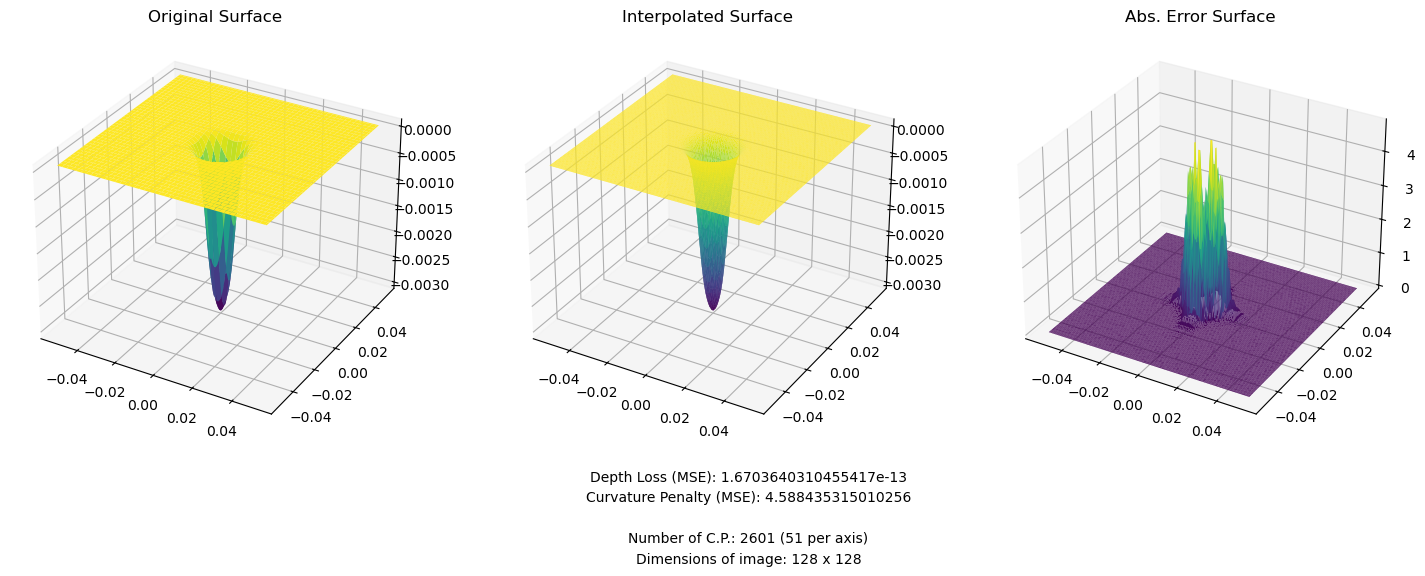

In [180]:
# Vectorize the Puff_profile function to handle arrays
Puff_profile_vectorized = np.vectorize(Puff_profile)
# Find the 3D profile
z = Puff_profile_vectorized(X, Y, t)

# Evaluate the interpolated surface
z_interp = bisplev(x, y, tck)

# Plotting
fig = plt.figure(figsize=(18, 12))

# Plot the original surface
ax1 = fig.add_subplot(131, projection='3d')
surf1=ax1.plot_surface(X, Y, z, cmap='viridis', edgecolor='none')
ax1.set_title('Original Surface')

#Plot the interpolated B-spline surface
ax2 = fig.add_subplot(132, projection='3d')
surf2=ax2.plot_trisurf(X.flatten(), Y.flatten(), z_interp.flatten(), cmap='viridis', edgecolor='none')
ax2.set_title('Interpolated Surface')

#Plot the error surface
ax3 = fig.add_subplot(133, projection='3d')
surf3=ax3.plot_trisurf(X.flatten(), Y.flatten(), np.abs((z-z_interp)).flatten(), cmap='viridis', edgecolor='none')
ax3.set_title('Abs. Error Surface')

#Print the depth loss, the curvatue penalty and the number of control points
ax1.text2D(1.8, -0.1, f'Depth Loss (MSE): {dm_loss}', transform=ax1.transAxes, ha='center')
ax1.text2D(1.8, -0.15, f'Curvature Penalty (MSE): {curv_loss}', transform=ax1.transAxes, ha='center')
#ax1.text2D(1.8, -0.2, f'Total Loss (kappa_1={kap_1}, kappa_2={1-kap_1}): {total_loss} ', transform=ax1.transAxes, ha='center')
ax1.text2D(1.8, -0.25, f'Number of C.P.: {(n+1)**2} ({(n+1)} per axis)', transform=ax1.transAxes, ha='center')
ax1.text2D(1.8, -0.30, f'Dimensions of image: {size} x {size}', transform=ax1.transAxes, ha='center')


plt.show()